## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
display(data.info())

data['date'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

<class 'pandas.core.series.Series'>
RangeIndex: 294478 entries, 0 to 294477
Series name: date
Non-Null Count   Dtype 
--------------   ----- 
294478 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'])
data.groupby(by='group').agg(['min', 'max'])

user_id               date            purchase     price        
          min     max        min        max      min max   min     max
group                                                                 
A      630002  945998 2021-01-02 2021-01-24        0   1     0  200000
B      630000  945999 2021-01-02 2021-01-24        0   1     0  200000

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
data['cost'] = data['purchase'] * data['price']
count_a = data.groupby(by='group')['user_id'].count()[0]
count_b = data.groupby(by='group')['user_id'].count()[1]
purchase_a = data.groupby(by='group')['purchase'].sum()[0]
purchase_b = data.groupby(by='group')['purchase'].sum()[1]
cost_a = data.groupby(by='group')['cost'].sum()[0] / 1000000
cost_b = data.groupby(by='group')['cost'].sum()[1] / 1000000
total_cost = data['cost'].sum() / 1000000

print('Количество посещений сайта:\nГруппа А: {}; Группа В: {}'.format(count_a, count_b))
print()
print('Суммарное количество покупок:\nГруппа А: {}; Группа В: {}'.format(purchase_a, purchase_b))
print()
print('Сумма всех покупок:\nГруппа А: {} млн.руб; Группа В: {} млн.руб'.format(cost_a, cost_b))

Количество посещений сайта:
Группа А: 147202; Группа В: 147276

Суммарное количество покупок:
Группа А: 17723; Группа В: 17514

Сумма всех покупок:
Группа А: 1436.26 млн.руб; Группа В: 1554.1 млн.руб


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])
set_a_b = set_a.intersection(set_b)
len(set_a_b)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
user_intersection = list(set_a_b)
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
 5   cost      290688 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 15.5+ MB


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

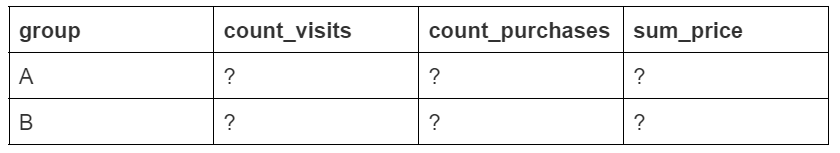
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [42]:
df =updated_data.groupby('group').agg({
    'user_id':'count', 
    'purchase':'sum',
    'cost':'sum',
    }).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'cost':'sum_price'})
df

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

## Промежуточные выводы:

* Количество посещений по группам практически идентично
* Как и количество совершенных покупок
* На данный момент можно сделать вывод, что **Выборки сбалансированны**

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [43]:
df['conversion'] = df['count_purchases'] / df['count_visits'] * 100
df['mean_check'] = df['sum_price'] / df['count_purchases']
df

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

## Промежуточные выводы:

* Коверсия в группе А больше (**всего на 0,14%**)
* Средний чек в группе В больше (**на 7588руб.**)
* На данном этапе явно выраженного **победителя нет**.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [44]:
heat_data = updated_data.pivot_table(
    values='cost',
    index='price',
    columns='group',
    aggfunc='count'
)
heat_data = heat_data.drop(labels=[0], axis=0)
heat_data

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot:xlabel='group', ylabel='price'>

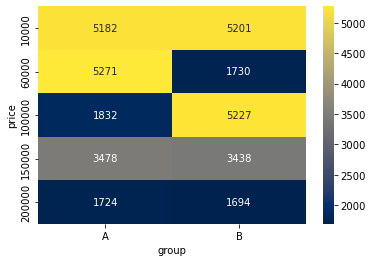

In [45]:
sns.heatmap(heat_data, cmap='cividis', annot=True, fmt="d")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

## Промежуточные выводы:

* Покупательская спосоность у группы А выше для туров за **60000 руб.**
* У группы В покупательская способность выше для туров за **100000 руб.**
* По остальным турам покупательские способности по группам А и В - **практически идентичны**

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [60]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'cost':'sum'
}).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'cost':'sum_price'})
daily_data['daily_converse'] = daily_data['count_purchases'] / daily_data['count_visits'] * 100
daily_data['daily_mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']
daily_data

count_visits  count_purchases  sum_price  daily_converse  \
date       group                                                             
2021-01-02 A              2854              359   29410000       12.578837   
           B              2861              345   29660000       12.058721   
2021-01-03 A              6596              748   62000000       11.340206   
           B              6619              754   65960000       11.391449   
2021-01-04 A              6566              799   64250000       12.168748   
           B              6536              764   68030000       11.689106   
2021-01-05 A              6433              790   64550000       12.280429   
           B              6511              749   63550000       11.503609   
2021-01-06 A              6606              764   63410000       11.565244   
           B              6751              838   75020000       12.412976   
2021-01-07 A              6579              795   67290000       12.083903   
           B              6616              767   67170000       11.593108   
2021-01-08 A              6687              798   65380000       11.933603   
           B              6714              812   71270000       12.094132   
2021-01-09 A              6633              794   65610000       11.970451   
           B              6628              784   71410000       11.828606   
2021-01-10 A              6659              759   58950000       11.398108   
           B              6701              846   78080000       12.624981   
2021-01-11 A              6699              797   58760000       11.897298   
           B              6679              770   66960000       11.528672   
2021-01-12 A              6540              795   68460000       12.155963   
           B              6635              807   70560000       12.162773   
2021-01-13 A              6564              764   63590000       11.639244   
           B              6495              720   65910000       11.085450   
2021-01-14 A              6543              825   65890000       12.608895   
           B              6608              792   68990000       11.985472   
2021-01-15 A              6701              806   67570000       12.028056   
           B              6563              747   69160000       11.381990   
2021-01-16 A              6601              808   66210000       12.240570   
           B              6544              786   70560000       12.011002   
2021-01-17 A              6619              809   63020000       12.222390   
           B              6546              831   75300000       12.694775   
2021-01-18 A              6511              812   62850000       12.471203   
           B              6603              822   72240000       12.448887   
2021-01-19 A              6582              790   63680000       12.002431   
           B              6562              772   67820000       11.764706   
2021-01-20 A              6533              749   58710000       11.464871   
           B              6685              790   69250000       11.817502   
2021-01-21 A              6750              851   70300000       12.607407   
           B              6555              760   69870000       11.594203   
2021-01-22 A              6587              788   63690000       11.962957   
           B              6659              787   68660000       11.818591   
2021-01-23 A              6698              843   70950000       12.585847   
           B              6633              805   68930000       12.136288   
2021-01-24 A              3766              444   33250000       11.789697   
           B              3677              442   38650000       12.020669   

                  daily_mean_check  
date       group                    
2021-01-02 A          81922.005571  
           B          85971.014493  
2021-01-03 A          82887.700535  
           B          87480.106101  
2021-01-04 A          80413.016270  
           B  

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [61]:
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits'] *100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']
daily_data

count_visits  count_purchases  sum_price  daily_converse  \
date       group                                                             
2021-01-02 A              2854              359   29410000       12.578837   
           B              2861              345   29660000       12.058721   
2021-01-03 A              6596              748   62000000       11.340206   
           B              6619              754   65960000       11.391449   
2021-01-04 A              6566              799   64250000       12.168748   
           B              6536              764   68030000       11.689106   
2021-01-05 A              6433              790   64550000       12.280429   
           B              6511              749   63550000       11.503609   
2021-01-06 A              6606              764   63410000       11.565244   
           B              6751              838   75020000       12.412976   
2021-01-07 A              6579              795   67290000       12.083903   
           B              6616              767   67170000       11.593108   
2021-01-08 A              6687              798   65380000       11.933603   
           B              6714              812   71270000       12.094132   
2021-01-09 A              6633              794   65610000       11.970451   
           B              6628              784   71410000       11.828606   
2021-01-10 A              6659              759   58950000       11.398108   
           B              6701              846   78080000       12.624981   
2021-01-11 A              6699              797   58760000       11.897298   
           B              6679              770   66960000       11.528672   
2021-01-12 A              6540              795   68460000       12.155963   
           B              6635              807   70560000       12.162773   
2021-01-13 A              6564              764   63590000       11.639244   
           B              6495              720   65910000       11.085450   
2021-01-14 A              6543              825   65890000       12.608895   
           B              6608              792   68990000       11.985472   
2021-01-15 A              6701              806   67570000       12.028056   
           B              6563              747   69160000       11.381990   
2021-01-16 A              6601              808   66210000       12.240570   
           B              6544              786   70560000       12.011002   
2021-01-17 A              6619              809   63020000       12.222390   
           B              6546              831   75300000       12.694775   
2021-01-18 A              6511              812   62850000       12.471203   
           B              6603              822   72240000       12.448887   
2021-01-19 A              6582              790   63680000       12.002431   
           B              6562              772   67820000       11.764706   
2021-01-20 A              6533              749   58710000       11.464871   
           B              6685              790   69250000       11.817502   
2021-01-21 A              6750              851   70300000       12.607407   
           B              6555              760   69870000       11.594203   
2021-01-22 A              6587              788   63690000       11.962957   
           B              6659              787   68660000       11.818591   
2021-01-23 A              6698              843   70950000       12.585847   
           B              6633              805   68930000       12.136288   
2021-01-24 A              3766              444   33250000       11.789697   
           B              3677              442   38650000       12.020669   

                  daily_mean_check  cum_count_visits  cum_count_purchases  \
date       group                                                            
2021-01-02 A          81922.005571              2854                  359   
           B          85971.014493        

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

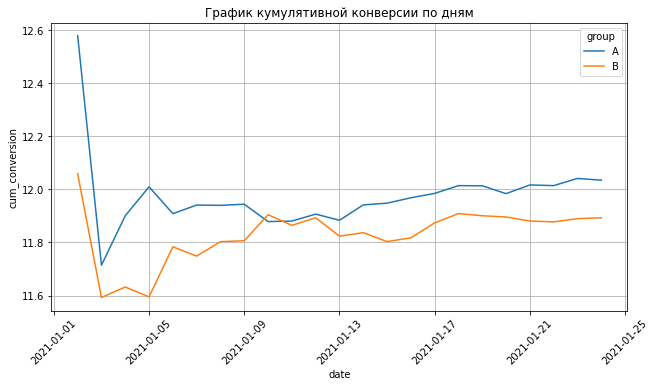

In [62]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

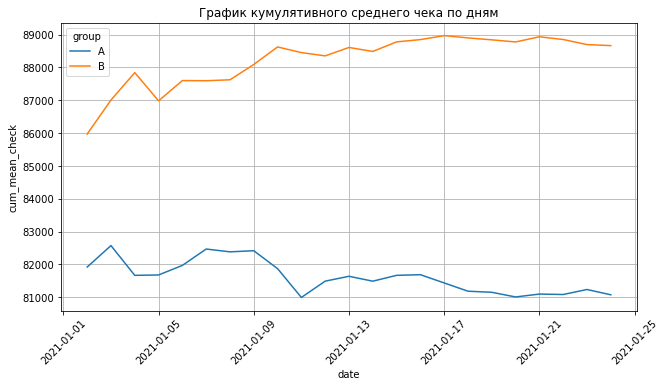

In [63]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

## Промежуточные выводы:

* До 09.01.21 конверсия была не стабильна, после 13.01.21 графики стабилизировались.
* Конверсия в группе А выше чем в группе В
* Средний чек так же стабилизируется после 13.01.21
* Средний чек в группе В стабильно выше чем в группе А
* **В целом кумулятивные метрики - стабильзировались**

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 